In [1]:
import numpy as np
import numpy.random as npr
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.linalg import orth
import time

from sca.models import SCA, WeightedPCA
from sca.util import get_sample_weights, get_accuracy

In [2]:
from nlb_tools.nwb_interface import NWBDataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import math
import multiprocessing as mp
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history
from Area2_analysis.lr_funcs import angle_between, process_train_test, gaussian_filter1d_oneside, comp_cc,xcorr
from Area2_analysis.lr_funcs import get_sses_pred, get_sses_mean, nans, fit_and_predict, sub_and_predict, pred_with_new_weights
matplotlib.rc('font', size=18)

2024-09-10 10:11:35.649884: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load data

In [3]:
foldername = "~/area2_population_analysis/s1-kinematics/actpas_NWB/"
monkey = "Han_20171207"
filename = foldername + monkey + "_COactpas_TD.nwb"

# monkey = 'Duncan_20190710'
# filename = foldername + monkey + "_COactpas_reformat.nwb"

dataset_10ms = NWBDataset(filename, split_heldout=False)
dataset_10ms.resample(10)
bin_width = dataset_10ms.bin_width
print(bin_width)

xy_vel = dataset_10ms.data['hand_vel'].to_numpy()
xy_acc = np.diff(xy_vel, axis = 0, prepend=[xy_vel[0]])
dataset_10ms.add_continuous_data(xy_acc,'hand_acc',chan_names = ['x','y'])


dataset_10ms.smooth_spk(40, name='smth_40')
dataset_10ms.smooth_spk(20, name='smth_20')



10


In [4]:
# dataset_20ms = NWBDataset(filename, split_heldout=False)
# dataset_20ms.resample(20)
# xy_vel = dataset_20ms.data['hand_vel'].to_numpy()
# xy_acc = np.diff(xy_vel, axis = 0, prepend=[xy_vel[0]])
# dataset_20ms.add_continuous_data(xy_acc,'hand_acc',chan_names = ['x','y'])
# bin_width = dataset_20ms.bin_width
# print(bin_width)

In [4]:
#make dictionary for trial condition (reaching directions) for Stratified CV
dataset = dataset_10ms
active_mask = (dataset.trial_info.ctr_hold_bump==0) & (dataset.trial_info['split'] != 'none')
passive_mask = (dataset.trial_info.ctr_hold_bump==1) & (dataset.trial_info['split'] != 'none')
nan_mask = (np.isnan(dataset.trial_info.ctr_hold_bump)) & (dataset.trial_info['split'] != 'none')
all_mask = (dataset.trial_info['split'] != 'none')

trial_mask = all_mask
valid_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(valid_n_trials,'valid trials')


trial_mask = active_mask
active_trials_idx = np.array(dataset.trial_info.loc[trial_mask]['trial_id'])
active_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(active_n_trials,'active trials')

trial_mask = passive_mask
passive_trials_idx = np.array(dataset.trial_info.loc[trial_mask]['trial_id'])
passive_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(passive_n_trials,'passive trials')

trial_mask = nan_mask
nan_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(nan_n_trials,'reach bump trials')

active_cond_dir_idx = []
passive_cond_dir_idx = []
for direction in [0,45,90,135,180,225,270,315]:
# for direction in [0,90,180,270]:
    active_cond_dir_idx.append(np.where((dataset.trial_info['cond_dir'] == direction) & (dataset.trial_info['ctr_hold_bump'] == 0) & \
           (dataset.trial_info['split'] != 'none'))[0])
    passive_cond_dir_idx.append(np.where((dataset.trial_info['cond_dir']%360 == direction) & (dataset.trial_info['ctr_hold_bump'] == 1) & \
           (dataset.trial_info['split'] != 'none'))[0])

active_cond_dict = nans([active_n_trials])
i = 0
for idx in active_trials_idx:
    for cond in range(0,len(active_cond_dir_idx)):
        if idx in active_cond_dir_idx[cond]:
            active_cond_dict[i] = cond
            break
    i+=1
print(active_cond_dict)
print(len(active_cond_dict))

passive_cond_dict = nans([passive_n_trials])
i = 0
for idx in passive_trials_idx:
    for cond in range(0,len(passive_cond_dir_idx)):
        if idx in passive_cond_dir_idx[cond]:
            passive_cond_dict[i] = cond
            break
    i+=1
print(passive_cond_dict)
print(len(passive_cond_dict))

463 valid trials
245 active trials
218 passive trials
0 reach bump trials
[6. 4. 5. 4. 0. 2. 0. 5. 4. 1. 6. 5. 6. 3. 7. 5. 2. 0. 0. 5. 0. 6. 4. 2.
 2. 7. 0. 4. 4. 7. 5. 2. 6. 3. 2. 5. 5. 1. 1. 5. 5. 1. 6. 3. 7. 0. 4. 2.
 1. 5. 1. 1. 1. 1. 1. 6. 2. 0. 5. 4. 7. 6. 3. 1. 5. 3. 0. 4. 6. 6. 0. 1.
 3. 0. 6. 3. 1. 4. 3. 4. 5. 2. 2. 3. 3. 3. 4. 4. 2. 1. 2. 2. 4. 6. 1. 5.
 0. 2. 0. 4. 6. 5. 6. 3. 0. 0. 6. 7. 2. 0. 0. 5. 7. 5. 1. 4. 2. 0. 0. 5.
 4. 6. 3. 6. 3. 6. 3. 1. 7. 3. 3. 7. 5. 5. 3. 1. 5. 0. 7. 4. 7. 5. 5. 1.
 6. 3. 3. 2. 1. 7. 5. 5. 0. 1. 6. 2. 7. 1. 0. 0. 3. 4. 1. 2. 0. 3. 0. 2.
 5. 1. 3. 0. 7. 2. 3. 1. 2. 2. 0. 4. 2. 1. 3. 5. 5. 2. 1. 4. 1. 1. 6. 4.
 1. 4. 7. 0. 2. 5. 6. 2. 1. 1. 5. 7. 1. 1. 2. 2. 5. 0. 6. 0. 0. 0. 3. 7.
 7. 0. 7. 0. 3. 0. 7. 7. 5. 3. 0. 7. 3. 0. 6. 4. 3. 0. 0. 4. 3. 3. 6. 1.
 0. 2. 0. 0. 3.]
245
[6. 3. 3. 2. 4. 0. 6. 1. 0. 3. 2. 7. 6. 6. 6. 5. 4. 5. 3. 0. 4. 1. 6. 6.
 1. 5. 1. 0. 7. 1. 4. 4. 7. 6. 7. 3. 3. 0. 3. 5. 6. 6. 3. 2. 1. 1. 4. 7.
 5. 4. 4. 4. 7. 4. 3. 0. 7. 0

In [5]:
active_df = dataset_10ms.make_trial_data(align_field='move_onset_time', align_range = (-100,1000), ignored_trials = ~active_mask)
set(active_trials_idx) - set(active_df['trial_id'].unique())

print('was',active_n_trials,'active trials')
active_n_trials = active_n_trials - len(list(set(active_trials_idx) - set(active_df['trial_id'].unique())))
active_cond_dict = np.delete(active_cond_dict,list(set(active_trials_idx) - set(active_df['trial_id'].unique())))
print('now',active_n_trials,'active trials')
print(len(active_cond_dict))

was 624 active trials
now 623 active trials
623


In [6]:
n_neurons = dataset_10ms.data.spikes.shape[1]
n_neurons

176

# PCA and SCA

## PCA

In [ ]:
align_range = (-100, 500)
all_trial_data = dataset_5ms.make_trial_data(align_field='move_onset_time', align_range=align_range, ignored_trials=~all_mask)
all_trial_spsm = np.array(all_trial_data.spikes_smth_40)
print(all_trial_spsm.shape)
all_data = np.array(dataset_5ms.data.spikes_smth_40)
print(all_data.shape)
if not np.isnan(all_trial_spsm).any():
    scaler = StandardScaler()
    X_trial = scaler.fit_transform(all_trial_spsm)
    pca = PCA(n_components=n_dims,random_state = 42)
    pca.fit(X_trial) # scaler and pca fit to trial data
    X_all = scaler.transform(all_data) #scaler and pca transform all data
    PCA_data = pca.transform(X_all)
print(PCA_data.shape)
dataset_5ms.add_continuous_data(PCA_data,'PCA_40')
print('PCA_40 var explained:',pca.explained_variance_ratio_)
print('PCA_40 total explained:',sum(pca.explained_variance_ratio_))

In [ ]:
align_range = (-100, 500)
all_trial_data = dataset_5ms.make_trial_data(align_field='move_onset_time', align_range=align_range, ignored_trials=~all_mask)
all_trial_spsm = np.array(all_trial_data.spikes_smth_20)
print(all_trial_spsm.shape)
all_data = np.array(dataset_5ms.data.spikes_smth_20)
print(all_data.shape)
if not np.isnan(all_trial_spsm).any():
    scaler = StandardScaler()
    X_trial = scaler.fit_transform(all_trial_spsm)
    pca = PCA(n_components=n_dims,random_state = 42)
    pca.fit(X_trial) # scaler and pca fit to trial data
    X_all = scaler.transform(all_data) #scaler and pca transform all data
    PCA_data = pca.transform(X_all)
print(PCA_data.shape)
dataset_5ms.add_continuous_data(PCA_data,'PCA_20')
print('PCA_20 var explained:',pca.explained_variance_ratio_)
print('PCA_20 total explained:',sum(pca.explained_variance_ratio_))

In [ ]:
align_range = (-100, 500)
all_trial_data = dataset_20ms.make_trial_data(align_field='move_onset_time', align_range=align_range, ignored_trials=~all_mask)
all_trial_spsm = np.array(all_trial_data.spikes)
print(all_trial_spsm.shape)
all_data = np.array(dataset_20ms.data.spikes)
print(all_data.shape)
if not np.isnan(all_trial_spsm).any():
    scaler = StandardScaler()
    X_trial = scaler.fit_transform(all_trial_spsm)
    pca = PCA(n_components=n_dims)
    pca.fit(X_trial) # scaler and sca fit to trial data
    X_all = scaler.transform(all_data) #scaler and sca transform all data
    PCA_data = pca.transform(X_all)
print(PCA_data.shape)
dataset_20ms.add_continuous_data(PCA_data,'PCA')
print('PCA var explained:',pca.explained_variance_ratio_)
print('PCA total explained:',sum(pca.explained_variance_ratio_))

In [ ]:
# Plot PCA projections over trial, for different reaching directions
dataset = dataset_5ms
plot_var = 'PCA_20'
align_range = (-100, 500)
trial_mask = passive_mask
cond_dict = passive_cond_dict
n_timepoints = int((align_range[1] - align_range[0])/dataset.bin_width)
n_trials = dataset.trial_info.loc[trial_mask].shape[0]
data = dataset.make_trial_data(align_field='move_onset_time', align_range=align_range, ignored_trials=~trial_mask)
trials_pca = nans([n_trials,n_timepoints,n_dims])
i = 0
for idx, trial in data.groupby('trial_id'):
    trials_pca[i,:,:]=trial[plot_var].to_numpy()
    i+=1
print(trials_pca.shape)

plot_dir = np.array([0,45,90,135,180,225,270,315]) 
directions = np.array([0,45,90,135,180,225,270,315])
x_axis = np.arange(align_range[0], align_range[1], dataset.bin_width)

# define some useful time points
move_idx=0
ret_idx = 120

import matplotlib as mpl
cmap = plt.get_cmap('coolwarm',len(plot_dir))
custom_palette = [mpl.colors.rgb2hex(cmap(i)) for i in range(len(plot_dir))]

plot_dims = 10

fig,ax=plt.subplots(plot_dims,1,figsize=(10,12))
for i in range(plot_dims):
    for j in range(len(plot_dir)):
        color = custom_palette[j]
        dir_idx = np.argwhere(directions == plot_dir[j])[0]
        cond_mean_proj = np.mean(trials_pca[np.argwhere(cond_dict==dir_idx).flatten(),:,:], axis = 0)[:,i] 
        pca_mean = np.mean(data[plot_var].to_numpy(),axis = 0)[i]
        ax[i].plot(x_axis,cond_mean_proj - pca_mean,linewidth=2.25,color = color,label = plot_dir[j])
        
        ax[i].axvline(move_idx, color='k',linewidth = .5)
        ax[i].axvline(ret_idx, color='k',linewidth = .5)
        # ax[i].set_xlim([-100,1000])
        # ax[i].set_ylim([-15, 15])
        ax[i].axhline(0,color ='k',ls = '--')
        if i<plot_dims-1:
            ax[i].set_xticks([])
        else:
            ax[i].set_xlabel('Time after movement onset (ms)')
            
        ax[i].set_yticks([])
        ax[i].set_ylabel('Dim. '+str(i+1))

    ax[0].set_title('Passive trials, '+ plot_var)
    
plt.legend(bbox_to_anchor = (1, 1), loc = 'upper left')
plt.tight_layout()

In [ ]:
# Plot PCA projections over trial, for different reaching directions
dataset = dataset_5ms
plot_var = 'PCA_20'
align_range = (-100, 500)
trial_mask = active_mask
cond_dict = active_cond_dict
n_timepoints = int((align_range[1] - align_range[0])/dataset.bin_width)
n_trials = dataset.trial_info.loc[trial_mask].shape[0]
data = dataset.make_trial_data(align_field='move_onset_time', align_range=align_range, ignored_trials=~trial_mask)
trials_pca = nans([n_trials,n_timepoints,n_dims])
i = 0
for idx, trial in data.groupby('trial_id'):
    trials_pca[i,:,:]=trial[plot_var].to_numpy()
    i+=1
print(trials_pca.shape)

plot_dir = np.array([0,45,90,135,180,225,270,315]) 
directions = np.array([0,45,90,135,180,225,270,315])
x_axis = np.arange(align_range[0], align_range[1], dataset.bin_width)

# define some useful time points
move_idx=0
ret_idx = 120

import matplotlib as mpl
cmap = plt.get_cmap('coolwarm',len(plot_dir))
custom_palette = [mpl.colors.rgb2hex(cmap(i)) for i in range(len(plot_dir))]

plot_dims = 10

fig,ax=plt.subplots(plot_dims,1,figsize=(10,12))
for i in range(plot_dims):
    for j in range(len(plot_dir)):
        color = custom_palette[j]
        dir_idx = np.argwhere(directions == plot_dir[j])[0]
        cond_mean_proj = np.mean(trials_pca[np.argwhere(cond_dict==dir_idx).flatten(),:,:], axis = 0)[:,i] 
        pca_mean = np.mean(data[plot_var].to_numpy(),axis = 0)[i]
        ax[i].plot(x_axis,cond_mean_proj - pca_mean,linewidth=2.25,color = color,label = plot_dir[j])
        
        ax[i].axvline(move_idx, color='k',linewidth = .5)
        ax[i].axvline(ret_idx, color='k',linewidth = .5)
        # ax[i].set_xlim([-100,1000])
        # ax[i].set_ylim([-15, 15])
        ax[i].axhline(0,color ='k',ls = '--')
        if i<plot_dims-1:
            ax[i].set_xticks([])
        else:
            ax[i].set_xlabel('Time after movement onset (ms)')
            
        ax[i].set_yticks([])
        ax[i].set_ylabel('Dim. '+str(i+1))

    ax[0].set_title('Active trials, '+ plot_var)
    
plt.legend(bbox_to_anchor = (1, 1), loc = 'upper left')
plt.tight_layout()

## SCA

In [5]:
n_dims = 20
align_range = (-200, 1000)
active_trial_data = dataset_10ms.make_trial_data(align_field='move_onset_time', align_range=align_range, ignored_trials=~active_mask, allow_overlap=True)
active_trial_spsm = np.array(active_trial_data.spikes_smth_40)
n_trials = active_trial_data['trial_id'].nunique()
n_timepoints = int((align_range[1]-align_range[0])/bin_width)
active_sample_weights= np.ones((n_trials, n_timepoints))
# active_sample_weights[:,:int(abs(align_range][0])/dataset_10ms.bin_width)] = 10
active_sample_weights = active_sample_weights.flatten()
print(active_sample_weights.shape)
sample_weights = active_sample_weights
print(sample_weights.shape)
all_trial_spsm = active_trial_spsm
print(all_trial_spsm.shape)


# align_range = (-100, 500)
# passive_trial_data = dataset_10ms.make_trial_data(align_field='move_onset_time', align_range=align_range, ignored_trials=~passive_mask)
# passive_trial_spsm = np.array(passive_trial_data.spikes_smth_40)
# n_trials = passive_trial_data['trial_id'].nunique()
# n_timepoints = int((align_range[1]-align_range[0])/bin_width)
# passive_sample_weights= np.ones((n_trials, n_timepoints))
# passive_sample_weights = passive_sample_weights.flatten()
# print(passive_sample_weights.shape)
# sample_weights = np.hstack((active_sample_weights, passive_sample_weights))
# print(sample_weights.shape)
# all_trial_spsm = np.concatenate((active_trial_spsm, passive_trial_spsm),axis=0)
# print(all_trial_spsm.shape)

all_data = np.array(dataset_10ms.data.spikes_smth_40)
print(all_data.shape)
if not np.isnan(all_trial_spsm).any():
    scaler = StandardScaler()
    X_trial = scaler.fit_transform(all_trial_spsm,sample_weight=sample_weights)
    sca = SCA(n_components=n_dims)
    sca.fit(X_trial) # scaler and sca fit to trial data
    X_all = scaler.transform(all_data) #scaler and sca transform all data
    SCA_data = sca.transform(X_all)
print(SCA_data.shape)
dataset_10ms.add_continuous_data(SCA_data,'SCA_40')
print('SCA_40 var explained:',sca.r2_score)
ssa_order_smth40=np.argsort(-np.array(sca.explained_squared_activity))
print('SCA_40 activity explained:',sca.explained_squared_activity[ssa_order_smth40])


(29400,)
(29400,)
(29400, 153)
(279131, 153)
Using lam_sparse=  0.3293474317903507
Using lam_orthog=  67997.30669453503
Using device cpu


100%|██████████| 3000/3000 [02:30<00:00, 19.93it/s]


(279131, 20)
SCA_40 var explained: 0.42383485412291766
SCA_40 activity explained: [306541.06  202164.08  167145.47  126646.06  124641.87   89993.13
  72634.12   67249.36   63830.066  61472.77   57129.44   53029.85
  50719.668  48111.52   44060.336  43090.52   42844.414  41989.605
  39699.555  36892.703]


In [36]:
n_dims = 20
align_range = (-200, 1500)
active_trial_data = dataset_10ms.make_trial_data(align_field='move_onset_time', align_range=align_range, ignored_trials=~active_mask, allow_overlap=True)
active_trial_spsm = np.array(active_trial_data.spikes_smth_20)
n_trials = active_trial_data['trial_id'].nunique()
n_timepoints = int((align_range[1]-align_range[0])/bin_width)
active_sample_weights= np.ones((n_trials, n_timepoints))
# active_sample_weights[:,:int(100/dataset_10ms.bin_width)] = 10
active_sample_weights = active_sample_weights.flatten()
print(active_sample_weights.shape)
sample_weights = active_sample_weights
print(sample_weights.shape)
all_trial_spsm = active_trial_spsm
print(all_trial_spsm.shape)

# align_range = (-200, 500)
# passive_trial_data = dataset_10ms.make_trial_data(align_field='move_onset_time', align_range=align_range, ignored_trials=~passive_mask)
# passive_trial_spsm = np.array(passive_trial_data.spikes_smth_20)
# n_trials = passive_trial_data['trial_id'].nunique()
# n_timepoints = int((align_range[1]-align_range[0])/bin_width)
# passive_sample_weights= np.ones((n_trials, n_timepoints))
# passive_sample_weights = passive_sample_weights.flatten()
# print(passive_sample_weights.shape)
# sample_weights = np.hstack((active_sample_weights, passive_sample_weights))
# print(sample_weights.shape)
# all_trial_spsm = np.concatenate((active_trial_spsm, passive_trial_spsm),axis=0)

all_data = np.array(dataset_10ms.data.spikes_smth_20)
print(all_data.shape)
if not np.isnan(all_trial_spsm).any():
    scaler = StandardScaler()
    X_trial = scaler.fit_transform(all_trial_spsm,sample_weight=sample_weights)
    sca = SCA(n_components=n_dims)
    sca.fit(X_trial) # scaler and sca fit to trial data
    X_all = scaler.transform(all_data) #scaler and sca transform all data
    SCA_data = sca.transform(X_all)
print(SCA_data.shape)
dataset_10ms.add_continuous_data(SCA_data,'SCA_20')
print('SCA_20 var explained:',sca.r2_score)
ssa_order_smth20=np.argsort(-np.array(sca.explained_squared_activity))
print('SCA_20 activity explained:',-np.sort(-sca.explained_squared_activity))

Allowed 44 overlapping trials.


(105910,)
(105910,)
(105910, 176)
(291494, 176)
Using lam_sparse=  0.49033015570526645
Using lam_orthog=  338236.28377376904
Using device cpu


100%|██████████| 3000/3000 [14:32<00:00,  3.44it/s]


(291494, 20)
SCA_20 var explained: 0.3071926462364101
SCA_20 activity explained: [754190.44 383193.8  319222.47 282463.28 278854.9  265597.88 255072.4
 247303.62 234931.23 233618.12 212209.1  209146.48 196313.31 186995.34
 180188.38 174800.25 172840.14 169593.86 149504.9  140415.22]


In [ ]:
# align_range = (-100, 500)
# all_trial_data = dataset_20ms.make_trial_data(align_field='move_onset_time', align_range=align_range, ignored_trials=~all_mask)
# all_trial_spsm = np.array(all_trial_data.spikes)
# print(all_trial_spsm.shape)
# all_data = np.array(dataset_20ms.data.spikes)
# print(all_data.shape)
# if not np.isnan(all_trial_spsm).any():
#     scaler = StandardScaler()
#     X_trial = scaler.fit_transform(all_trial_spsm)
#     sca = SCA(n_components=n_dims)
#     sca.fit(X_trial) # scaler and sca fit to trial data
#     X_all = scaler.transform(all_data) #scaler and sca transform all data
#     SCA_data = sca.transform(X_all)
# print(SCA_data.shape)
# dataset_20ms.add_continuous_data(SCA_data,'SCA')
# print('SCA var explained:',sca.r2_score)
# print('SCA activity explained:',sca.explained_squared_activity)
# ssa_order_bin=np.argsort(-np.array(sca.explained_squared_activity))


(13475, 153)
(139566, 153)
Using lam_sparse=  0.5622568176715524
Using lam_orthog=  40894.50488998484
Using device cpu


100%|██████████| 3000/3000 [01:11<00:00, 41.95it/s]


(139566, 20)
SCA var explained: 0.2383877150263456
SCA activity explained: [34959.957 31242.77  36792.516 22046.25  19278.445 24286.504 25724.21
 21242.438 16275.561 22885.83  25845.418 17432.139 18785.592 18526.367
 15456.014 13808.767 15301.578 15108.597 13222.075 13060.947]


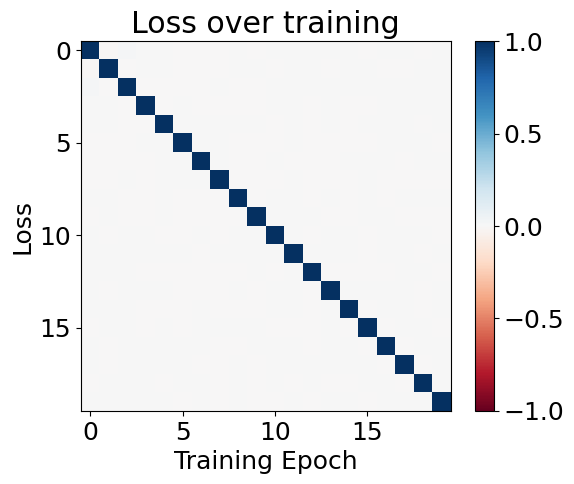

In [ ]:
# plt.figure()
# plt.plot(sca.losses)
# plt.xlabel('Training Epoch')
# plt.ylabel('Loss')
# plt.title('Loss over training')
# plt.imshow(product,clim=[-1,1],cmap='RdBu')
# plt.colorbar()

(218, 60, 20)


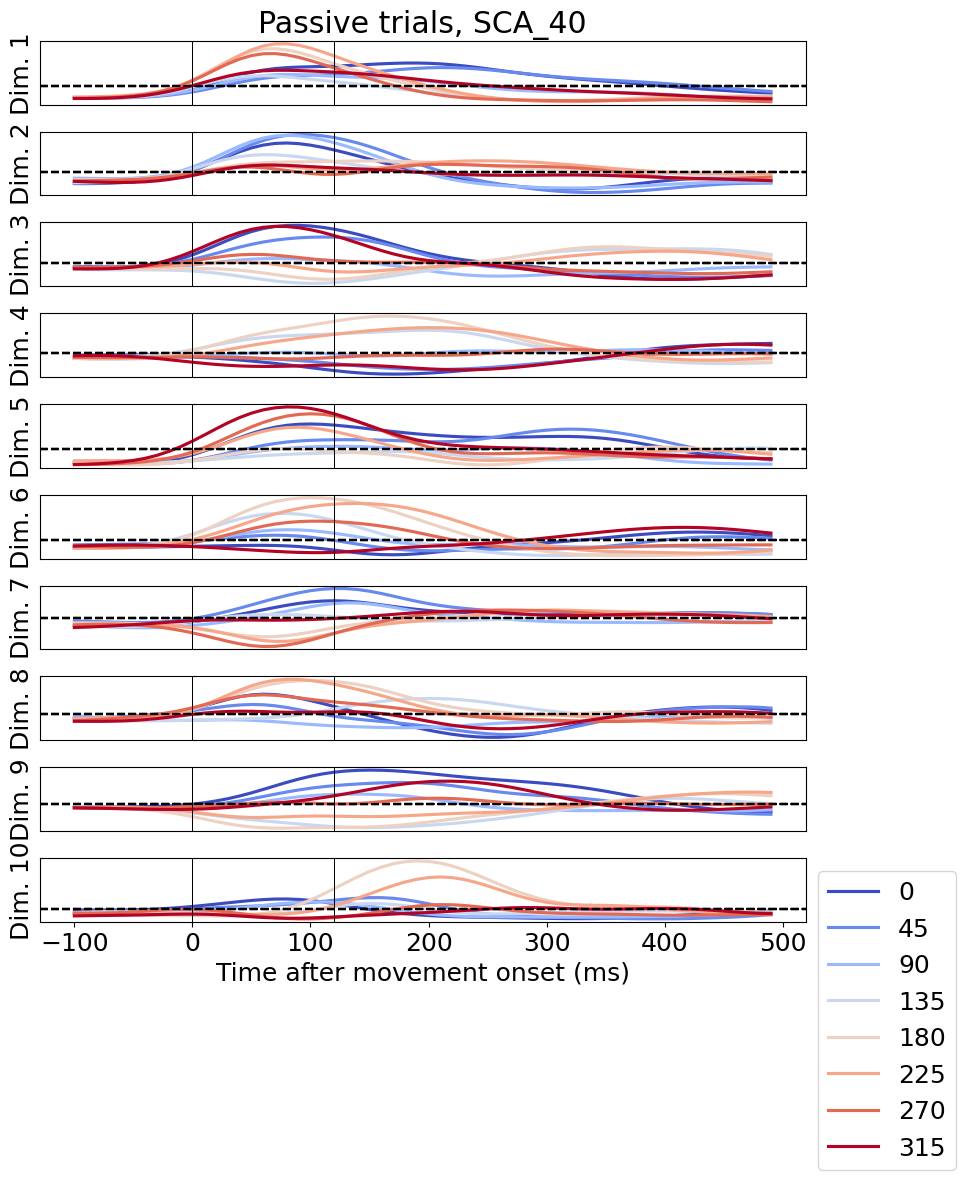

In [6]:
# Plot SCA projections over trial, for different reaching directions
dataset = dataset_10ms
# plot_var = 'SCA_20'
# order = ssa_order_smth20

plot_var = 'SCA_40'
order = ssa_order_smth40

# dataset = dataset_20ms
# plot_var = 'SCA'
# order = ssa_order_bin

align_range = (-100, 500)
trial_mask = passive_mask
cond_dict = passive_cond_dict
n_timepoints = int((align_range[1] - align_range[0])/dataset.bin_width)
n_trials = dataset.trial_info.loc[trial_mask].shape[0]
data = dataset.make_trial_data(align_field='move_onset_time', align_range=align_range, ignored_trials=~trial_mask)
trials_sca = nans([n_trials,n_timepoints,n_dims])
i = 0
for idx, trial in data.groupby('trial_id'):
    trials_sca[i,:,:]=trial[plot_var].to_numpy()
    i+=1
print(trials_sca.shape)

plot_dir = np.array([0,45,90,135,180,225,270,315]) 
directions = np.array([0,45,90,135,180,225,270,315])
x_axis = np.arange(align_range[0], align_range[1], dataset.bin_width)

# define some useful time points
move_idx=0
ret_idx = 120

import matplotlib as mpl
cmap = plt.get_cmap('coolwarm',len(plot_dir))
custom_palette = [mpl.colors.rgb2hex(cmap(i)) for i in range(len(plot_dir))]

plot_dims = 10

fig,ax=plt.subplots(plot_dims,1,figsize=(10,12))
for i in range(plot_dims):
    for j in range(len(plot_dir)):
        color = custom_palette[j]
        dir_idx = np.argwhere(directions == plot_dir[j])[0]
        cond_mean_proj = np.mean(trials_sca[np.argwhere(cond_dict==dir_idx).flatten(),:,:], axis = 0)[:,order[i]] 
        sca_mean = np.mean(data[plot_var].to_numpy(),axis = 0)[order[i]]
        ax[i].plot(x_axis,cond_mean_proj - sca_mean,linewidth=2.25,color = color,label = plot_dir[j])
        
        ax[i].axvline(move_idx, color='k',linewidth = .5)
        ax[i].axvline(ret_idx, color='k',linewidth = .5)
        # ax[i].set_xlim([-100,500])
        # ax[i].set_ylim([-15, 15])
        ax[i].axhline(0,color ='k',ls = '--')
        if i<plot_dims-1:
            ax[i].set_xticks([])
        else:
            ax[i].set_xlabel('Time after movement onset (ms)')
            
        ax[i].set_yticks([])
        ax[i].set_ylabel('Dim. '+str(i+1))

    ax[0].set_title('Passive trials, '+ plot_var)
    
plt.legend(bbox_to_anchor = (1, 1), loc = 'upper left')
plt.tight_layout()

(245, 110, 20)


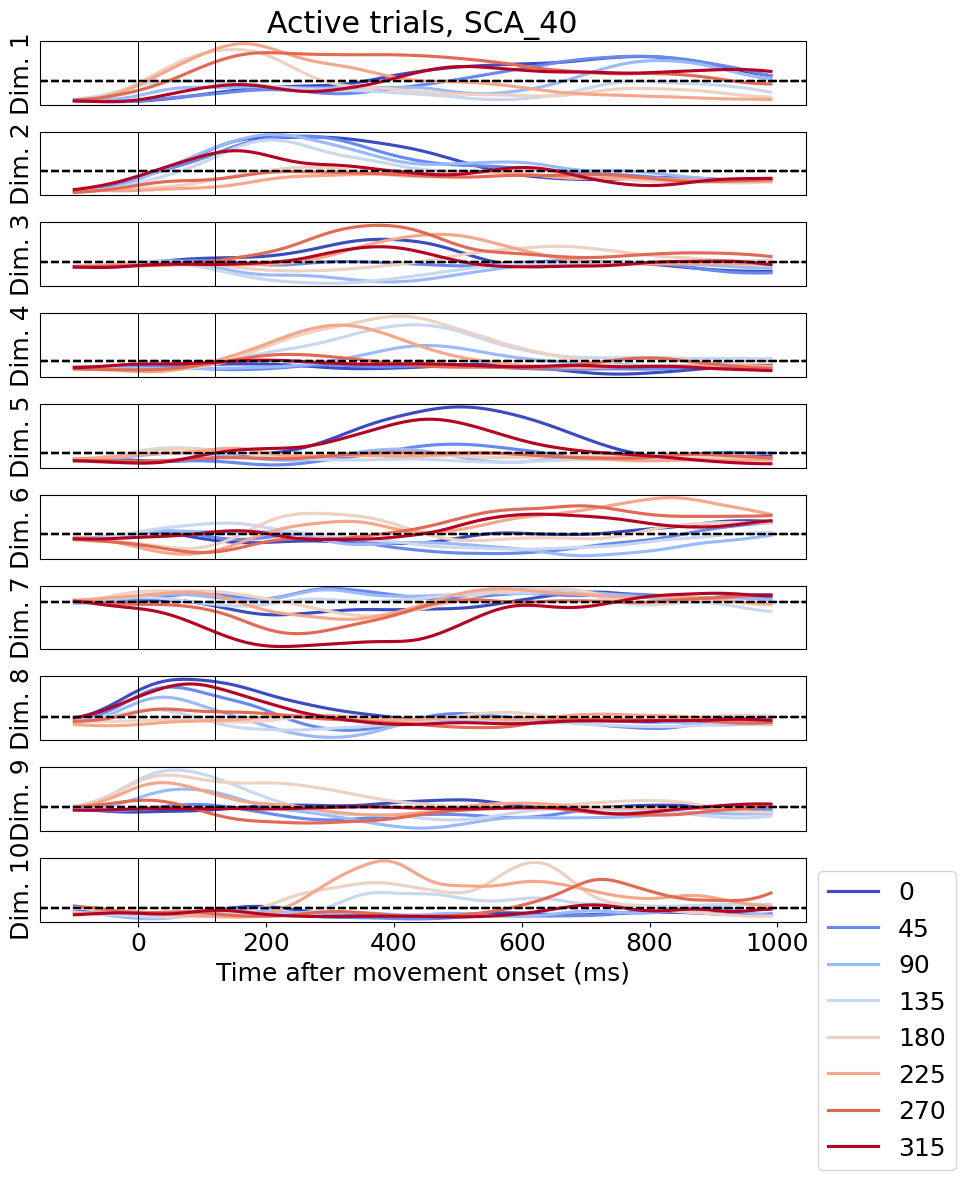

In [7]:
# Plot SCA projections over trial, for different reaching directions
dataset = dataset_10ms
# plot_var = 'SCA_20'
# order = ssa_order_smth20

plot_var = 'SCA_40'
order = ssa_order_smth40

# dataset = dataset_20ms
# plot_var = 'SCA'
# order = ssa_order_bin
   
align_range = (-100, 1000)
trial_mask = active_mask
cond_dict = active_cond_dict
n_timepoints = int((align_range[1] - align_range[0])/dataset.bin_width)
data = dataset.make_trial_data(align_field='move_onset_time', align_range=align_range, ignored_trials=~trial_mask, allow_overlap=True)
n_trials = data['trial_id'].nunique()
trials_pca = nans([n_trials,n_timepoints,n_dims])
i = 0
for idx, trial in data.groupby('trial_id'):
    trials_pca[i,:,:]=trial[plot_var].to_numpy()
    i+=1
print(trials_pca.shape)

plot_dir = np.array([0,45,90,135,180,225,270,315]) 
directions = np.array([0,45,90,135,180,225,270,315])
x_axis = np.arange(align_range[0], align_range[1], dataset.bin_width)

# define some useful time points
move_idx=0
ret_idx = 120

import matplotlib as mpl
cmap = plt.get_cmap('coolwarm',len(plot_dir))
custom_palette = [mpl.colors.rgb2hex(cmap(i)) for i in range(len(plot_dir))]

plot_dims = 10

fig,ax=plt.subplots(plot_dims,1,figsize=(10,12))
for i in range(plot_dims):
    for j in range(len(plot_dir)):
        color = custom_palette[j]
        dir_idx = np.argwhere(directions == plot_dir[j])[0]
        cond_mean_proj = np.mean(trials_pca[np.argwhere(cond_dict==dir_idx).flatten(),:,:], axis = 0)[:,order[i]] 
        pca_mean = np.mean(data[plot_var].to_numpy(),axis = 0)[order[i]]
        ax[i].plot(x_axis,cond_mean_proj - pca_mean,linewidth=2.25,color = color,label = plot_dir[j])
        
        ax[i].axvline(move_idx, color='k',linewidth = .5)
        ax[i].axvline(ret_idx, color='k',linewidth = .5)
        # ax[i].set_xlim([-100,500])
        # ax[i].set_ylim([-15, 15])
        ax[i].axhline(0,color ='k',ls = '--')
        if i<plot_dims-1:
            ax[i].set_xticks([])
        else:
            ax[i].set_xlabel('Time after movement onset (ms)')
            
        ax[i].set_yticks([])
        ax[i].set_ylabel('Dim. '+str(i+1))

    ax[0].set_title('Active trials, '+ plot_var)
    
plt.legend(bbox_to_anchor = (1, 1), loc = 'upper left')
plt.tight_layout()

# Reaching direction

In [ ]:
def procX_train_test(X,y,training_set,test_set):
    X_train = X[training_set,:]
    X_test = X[test_set,:]
    y_train = y[training_set,:]
    y_test = y[test_set,:]    
    
    X_train_mean=np.nanmean(X_train,axis=0)
    X_train_std=np.nanstd(X_train,axis=0)   

    X_train=(X_train-X_train_mean)/X_train_std
    X_test=(X_test-X_train_mean)/X_train_std
 
    return X_train,X_test,y_train,y_test

In [ ]:
pred_range = (-200, 1000)
mask = active_mask
n_trials = active_n_trials
cond_dict = active_cond_dict
dim = n_dims
active_df = dataset_20ms.make_trial_data(align_field='move_onset_time', align_range=pred_range, ignored_trials=~mask)
dirs = [dataset_20ms.trial_info[dataset_20ms.trial_info.trial_id == i]['cond_dir'] for i in active_df.trial_id]
cos_x = [round(math.cos(math.radians(i)),3) for i in dirs]
sin_y = [round(math.sin(math.radians(i)),3) for i in dirs]
cos_sin = np.array([cos_x, sin_y]).T
act_trial_PCA = active_df.PCA.to_numpy().reshape((n_trials, -1, dim))
print(act_trial_PCA.shape)
# act_trial_ang = cos_sin.reshape((n_trials, -1, 2))
act_trial_ang = np.array(cos_x).T.reshape((n_trials,-1,1))
print(act_trial_ang.shape)

In [ ]:
n_bins = act_trial_PCA.shape[1]
act_coefs_arr = nans([n_bins, 1, dim])
act_offset_arr = nans([n_bins, 1])

act_r2_arr = nans([n_bins])
for i in range(n_bins):
    X = act_trial_PCA[:,i,:]
    Y = act_trial_ang[:,i,:]
    X_proc = (X - np.nanmean(X,axis=0))/np.nanstd(X,axis=0)
    lr_all = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 1, 6)})
    lr_all.fit(X_proc, Y)
    act_coefs_arr[i,:,:] = lr_all.best_estimator_.coef_
    act_offset_arr[i,:] = lr_all.best_estimator_.intercept_
    skf = StratifiedKFold(n_splits=5,shuffle=True,random_state = 42)
    true_concat = nans([n_trials,2])
    pred_concat = nans([n_trials,2])
    trial_save_idx = 0
    for training_set, test_set in skf.split(range(0,n_trials),cond_dict):
        #split training and testing by trials
        X_train, X_test, y_train, y_test = procX_train_test(X,Y,training_set,test_set)
        lr = Ridge(alpha=lr_all.best_params_['alpha'])
        lr.fit(X_train, y_train)
        y_test_predicted = lr.predict(X_test)

        n = y_test_predicted.shape[0]
        true_concat[trial_save_idx:trial_save_idx+n,:] = y_test
        pred_concat[trial_save_idx:trial_save_idx+n,:] = y_test_predicted
        trial_save_idx += n

    sses =get_sses_pred(true_concat,pred_concat)
    sses_mean=get_sses_mean(true_concat)
    R2 =1-np.sum(sses)/np.sum(sses_mean)     
    act_r2_arr[i] = R2

In [ ]:
pred_range = (-200, 1000)
mask = passive_mask
n_trials = passive_n_trials
cond_dict = passive_cond_dict
passive_df = dataset_20ms.make_trial_data(align_field='move_onset_time', align_range=pred_range, ignored_trials=~mask)
dirs = [dataset_20ms.trial_info[dataset_20ms.trial_info.trial_id == i]['cond_dir'] for i in passive_df.trial_id]
cos_x = [round(math.cos(math.radians(i)),3) for i in dirs]
sin_y = [round(math.sin(math.radians(i)),3) for i in dirs]
cos_sin = np.array([cos_x, sin_y]).T
pas_trial_PCA = passive_df.PCA.to_numpy().reshape((n_trials, -1, dim))
print(pas_trial_PCA.shape)
# pas_trial_ang = cos_sin.reshape((n_trials, -1, 2))
pas_trial_ang = np.array(cos_x).T.reshape((n_trials,-1,1))
print(pas_trial_ang.shape)

In [ ]:
pas_coefs_arr = nans([n_bins, 1, dim])
pas_offset_arr = nans([n_bins, 1])
pas_r2_arr = nans([n_bins])
for i in range(n_bins):
    X = pas_trial_PCA[:,i,:]
    Y = pas_trial_ang[:,i,:]
    X_proc = (X - np.nanmean(X,axis=0))/np.nanstd(X,axis=0)
    lr_all = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 1, 6)})
    lr_all.fit(X_proc, Y)
    pas_coefs_arr[i,:,:] = lr_all.best_estimator_.coef_
    pas_offset_arr[i,:] = lr_all.best_estimator_.intercept_
    skf = StratifiedKFold(n_splits=5,shuffle=True,random_state = 42)
    true_concat = nans([n_trials,2])
    pred_concat = nans([n_trials,2])
    trial_save_idx = 0
    for training_set, test_set in skf.split(range(0,n_trials),cond_dict):
        #split training and testing by trials
        X_train, X_test, y_train, y_test = procX_train_test(X,Y,training_set,test_set)
        lr = Ridge(alpha=lr_all.best_params_['alpha'])
        lr.fit(X_train, y_train)
        y_test_predicted = lr.predict(X_test)

        n = y_test_predicted.shape[0]
        true_concat[trial_save_idx:trial_save_idx+n,:] = y_test
        pred_concat[trial_save_idx:trial_save_idx+n,:] = y_test_predicted
        trial_save_idx += n

    sses =get_sses_pred(true_concat,pred_concat)
    sses_mean=get_sses_mean(true_concat)
    R2 =1-np.sum(sses)/np.sum(sses_mean)     
    pas_r2_arr[i] = R2

In [ ]:
lag_axis = np.arange(-200,1000,20)
plt.plot(lag_axis,act_r2_arr, color = 'k', label = 'Active')
plt.plot(lag_axis,pas_r2_arr, color = 'red', label = 'Passive')
plt.xlabel('Time (ms)'); plt.ylabel('R2'); plt.title('Reaching dir., cosine')
plt.legend()
plt.axvline(0, color = 'k',linestyle = '--')
plt.axvline(60, color = 'k',linestyle = '--')


In [ ]:
act_coef = act_coefs_arr[np.argwhere(np.arange(-200, 1000,20)==0)[0,0]]
act_offset = act_offset_arr[np.argwhere(np.arange(-200, 1000,20)==0)[0,0]]

pas_coef = pas_coefs_arr[np.argwhere(np.arange(-200, 1000,20)==60)[0,0]]
pas_offset = pas_offset_arr[np.argwhere(np.arange(-200, 1000,20)==60)[0,0]]

In [ ]:
from Area2_analysis.lr_funcs import calc_proj
n_bins = act_trial_PCA.shape[1]
act_sub_coefs_arr = nans([n_bins, 1, dim])
act_sub_offset_arr = nans([n_bins, 1])

act_sub_r2_arr = nans([n_bins])
for i in range(n_bins):
    X = act_trial_PCA[:,i,:]
    Y = act_trial_ang[:,i,:]
    X_proc = (X - np.nanmean(X,axis=0))/np.nanstd(X,axis=0)
    X_sub = X_proc - calc_proj(X_proc,act_coef.T).T
    lr_all = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 1, 6)})
    lr_all.fit(X_sub, Y)
    act_sub_coefs_arr[i,:,:] = lr_all.best_estimator_.coef_
    act_sub_offset_arr[i,:] = lr_all.best_estimator_.intercept_
    skf = StratifiedKFold(n_splits=5,shuffle=True,random_state = 42)
    true_concat = nans([n_trials,2])
    pred_concat = nans([n_trials,2])
    trial_save_idx = 0
    X = X_sub * np.nanstd(X,axis=0) + np.nanmean(X,axis=0)
    for training_set, test_set in skf.split(range(0,n_trials),cond_dict):
        #split training and testing by trials
        X_train, X_test, y_train, y_test = procX_train_test(X,Y,training_set,test_set)
        lr = Ridge(alpha=lr_all.best_params_['alpha'])
        lr.fit(X_train, y_train)
        y_test_predicted = lr.predict(X_test)

        n = y_test_predicted.shape[0]
        true_concat[trial_save_idx:trial_save_idx+n,:] = y_test
        pred_concat[trial_save_idx:trial_save_idx+n,:] = y_test_predicted
        trial_save_idx += n

    sses =get_sses_pred(true_concat,pred_concat)
    sses_mean=get_sses_mean(true_concat)
    R2 =1-np.sum(sses)/np.sum(sses_mean)     
    act_sub_r2_arr[i] = R2

In [ ]:
pas_sub_coefs_arr = nans([n_bins, 1, dim])
pas_sub_offset_arr = nans([n_bins, 1])

pas_sub_r2_arr = nans([n_bins])
for i in range(n_bins):
    X = pas_trial_PCA[:,i,:]
    Y = pas_trial_ang[:,i,:]
    X_proc = (X - np.nanmean(X,axis=0))/np.nanstd(X,axis=0)
    X_sub = X_proc - calc_proj(X_proc,pas_coef.T).T
    lr_all = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 1, 6)})
    lr_all.fit(X_sub, Y)
    pas_sub_coefs_arr[i,:,:] = lr_all.best_estimator_.coef_
    pas_sub_offset_arr[i,:] = lr_all.best_estimator_.intercept_
    skf = StratifiedKFold(n_splits=5,shuffle=True,random_state = 42)
    true_concat = nans([n_trials,2])
    pred_concat = nans([n_trials,2])
    trial_save_idx = 0
    X = X_sub * np.nanstd(X,axis=0) + np.nanmean(X,axis=0)
    for training_set, test_set in skf.split(range(0,n_trials),cond_dict):
        #split training and testing by trials
        X_train, X_test, y_train, y_test = procX_train_test(X,Y,training_set,test_set)
        lr = Ridge(alpha=lr_all.best_params_['alpha'])
        lr.fit(X_train, y_train)
        y_test_predicted = lr.predict(X_test)

        n = y_test_predicted.shape[0]
        true_concat[trial_save_idx:trial_save_idx+n,:] = y_test
        pred_concat[trial_save_idx:trial_save_idx+n,:] = y_test_predicted
        trial_save_idx += n

    sses =get_sses_pred(true_concat,pred_concat)
    sses_mean=get_sses_mean(true_concat)
    R2 =1-np.sum(sses)/np.sum(sses_mean)     
    pas_sub_r2_arr[i] = R2

In [ ]:
#Predict passive trials

from Neural_Decoding.metrics import get_R2
act_pas = nans([n_bins])
act_pas_rev = nans([n_bins])
pas_best = nans([n_bins])

for i in range(n_bins):
    X_train = act_trial_PCA[:,i,:]
    X = pas_trial_PCA[:,i,:]
    Y = pas_trial_ang[:,i,:]
    X_proc = (X - np.mean(X_train,axis=0))/np.std(X_train,axis=0)
    Y_hat = X_proc@act_coef.T + act_offset
    R2 =get_R2(Y,Y_hat)   
    act_pas[i] = R2
    R2 = get_R2(Y,-Y_hat)  
    act_pas_rev[i] = R2

    X_proc = (X - np.mean(X,axis=0))/np.std(X,axis=0)
    Y_hat = X_proc@pas_coef.T + pas_offset
    R2 =get_R2(Y,Y_hat)     
    pas_best[i] = R2

In [ ]:
#Predict active trials
pas_act = nans([n_bins])
pas_act_rev = nans([n_bins])
act_best = nans([n_bins])

for i in range(n_bins):
    X_train = pas_trial_PCA[:,i,:]
    X = act_trial_PCA[:,i,:]
    Y = act_trial_ang[:,i,:]
    X_proc = (X - np.mean(X_train,axis=0))/np.std(X_train,axis=0)
    Y_hat = X_proc@pas_coef.T + pas_offset
    R2 =get_R2(Y,Y_hat)      
    pas_act[i] = R2
    R2 =get_R2(Y,-Y_hat)  
    pas_act_rev[i] = R2

    X_proc = (X - np.mean(X,axis=0))/np.std(X,axis=0)
    Y_hat = X_proc@act_coef.T + act_offset
    R2 =get_R2(Y,Y_hat)       
    act_best[i] = R2

In [ ]:
lag_axis = np.arange(-200,1000,20)
plt.plot(lag_axis,act_r2_arr, color = 'k', label = 'Active')
plt.plot(lag_axis,act_best, alpha = 0.5, label = 'Active_0ms')
plt.plot(lag_axis,act_sub_r2_arr, alpha = 0.5, label = 'Active_sub')
plt.legend()

In [ ]:
lag_axis = np.arange(-200,1000,20)
plt.plot(lag_axis,pas_r2_arr, color = 'red', label = 'Passive')
plt.plot(lag_axis,pas_best, alpha = 0.5, label = 'Passive_60ms')
plt.plot(lag_axis,pas_sub_r2_arr, alpha = 0.5, label = 'Passive_sub')
plt.legend()

In [ ]:
lag_axis = np.arange(-200,1000,20)
plt.plot(lag_axis,act_r2_arr, color = 'k', label = 'Active')
plt.plot(lag_axis,pas_act, color = 'magenta', alpha = 1, label = 'Active by pas_60ms')
plt.plot(lag_axis,pas_act_rev, color = 'magenta', alpha =.1, label = 'rev Active by pas_60ms')
plt.plot(lag_axis,act_best, color = 'green', alpha =1, label = 'Active by act_0ms')

plt.xlabel('Time (ms)'); plt.ylabel('R2'); plt.title('Active cosine decoding')
plt.legend(fontsize=12)
plt.axvline(0, color = 'k',linestyle = '--')

In [ ]:
lag_axis = np.arange(-200,1000,20)
plt.plot(lag_axis,pas_r2_arr, color = 'red', label = 'Passive')
plt.plot(lag_axis,act_pas, color = 'green', alpha =.1, label = 'Passive by act_0ms')
plt.plot(lag_axis,act_pas_rev, color = 'green', alpha =1, label = 'rev Passive by act_0ms')
plt.plot(lag_axis,pas_best, color = 'magenta', alpha =1, label = 'Passive by pas_60ms')

plt.xlabel('Time (ms)'); plt.ylabel('R2'); plt.title('Passive cosine decoding')
plt.legend(fontsize=12)
plt.axvline(0, color = 'k',linestyle = '--')

In [ ]:
angDist_array = nans([len(act_coefs_arr),len(act_coefs_arr)])

for i in range(len(lag_axis)):
    for j in range(len(lag_axis)):
        angDist_array[i,j] = math.degrees(angle_between(act_coefs_arr[i,0,:],act_coefs_arr[j,0,:]))
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(angDist_array)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Time (ms)')

ax.set_xticks(np.arange(len(lag_axis)))
ax.set_yticks(np.arange(len(lag_axis)))
ax.set_xticklabels(labels=lag_axis)
ax.set_yticklabels(labels=lag_axis)

ax.set_title("Active, cosine decoder angles")

for i in range(len(lag_axis)):
    for j in range(len(lag_axis)):
        text = ax.text(j, i, str(int(angDist_array[i, j])),
                        ha="center", va="center", color="w", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
angDist_array = nans([len(pas_coefs_arr),len(pas_coefs_arr)])

for i in range(len(lag_axis)):
    for j in range(len(lag_axis)):
        angDist_array[i,j] = math.degrees(angle_between(pas_coefs_arr[i,0,:],pas_coefs_arr[j,0,:]))
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(angDist_array)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Time (ms)')

ax.set_xticks(np.arange(len(lag_axis)))
ax.set_yticks(np.arange(len(lag_axis)))
ax.set_xticklabels(labels=lag_axis)
ax.set_yticklabels(labels=lag_axis)

ax.set_title("Passive, cosine decoder angles")

for i in range(len(lag_axis)):
    for j in range(len(lag_axis)):
        text = ax.text(j, i, str(int(angDist_array[i, j])),
                        ha="center", va="center", color="w", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
angDist_array = nans([len(pas_coefs_arr),len(pas_coefs_arr)])

for i in range(len(lag_axis)):
    for j in range(len(lag_axis)):
        angDist_array[i,j] = math.degrees(angle_between(act_coefs_arr[i,0,:],pas_coefs_arr[j,0,:]))
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(angDist_array)
ax.set_xlabel('Passive time (ms)')
ax.set_ylabel('Active time (ms)')

ax.set_xticks(np.arange(len(lag_axis)))
ax.set_yticks(np.arange(len(lag_axis)))
ax.set_xticklabels(labels=lag_axis)
ax.set_yticklabels(labels=lag_axis)

ax.set_title("Act-Pas, cosine decoder angles")

for i in range(len(lag_axis)):
    for j in range(len(lag_axis)):
        text = ax.text(j, i, str(int(angDist_array[i, j])),
                        ha="center", va="center", color="w", fontsize=14)
plt.tight_layout()
plt.show()

# Kinematics

In [ ]:
# %matplotlib inline
# plt.close()
# dataset = dataset_5ms
# x_field = 'PCA_20'
# y_field ='hand_vel'
# lag_axis = np.arange(-300,300,20)
# dim = n_dims

# # Get a from passive trials
# pred_range = (-200, 120)
# pas_r2_array = nans([len(lag_axis)])
# pas_coef_array = nans([len(lag_axis),2,dim])
# for i in range(len(lag_axis)):
#     lag = lag_axis[i]
#     r2, coef,_,_ = fit_and_predict(dataset, passive_mask, 'move_onset_time',pred_range, lag, x_field, y_field,passive_cond_dict)
#     pas_r2_array[i] = r2
#     pas_coef_array[i,:,:] = coef
# pas_time_max = lag_axis[np.argmax(pas_r2_array)]
# print(pas_time_max)
# pas_aff_coef = pas_coef_array[np.argmax(pas_r2_array),:,:]
# plt.plot(lag_axis, pas_r2_array,color = 'k')
# plt.axvline(pas_time_max, color = 'k', linestyle='--')
# plt.xlabel('Time lag (ms)')
# plt.ylabel('R2')

In [ ]:
# # Get a* and e from active trials
# dataset = dataset_5ms
# x_field = 'PCA_20'
# y_field ='hand_vel'
# lag_axis = np.arange(-300,300,20)
# dim = n_dims

# pred_range_list = [(0, 500),(500, 1000)]
# # pred_range_list = [(-100, 1000)]
# for pred_range in pred_range_list:
#     act_r2_array = nans([len(lag_axis)])
#     act_coef_array = nans([len(lag_axis),2,dim])
#     for i in range(len(lag_axis)):
#         lag = lag_axis[i]
#         r2, coef,_,_ = fit_and_predict(dataset, active_mask, 'move_onset_time',pred_range, lag, x_field, y_field, active_cond_dict)
#         act_r2_array[i] = r2
#         act_coef_array[i,:,:] = coef

#     idx_max_pos = np.argwhere(act_r2_array == np.max(act_r2_array[np.argwhere(lag_axis==0)[0,0]:]))[0,0]
#     idx_max_neg = np.argwhere(act_r2_array == np.max(act_r2_array[:np.argwhere(lag_axis==0)[0,0]]))[0,0]
#     print(lag_axis[idx_max_pos])
#     print(lag_axis[idx_max_neg])

#     plt.plot(lag_axis, act_r2_array, label = str(pred_range))
#     # plt.axvline(lag_axis[idx_max_pos], color = 'k', linestyle='--')
#     # plt.axvline(lag_axis[idx_max_neg], color = 'k', linestyle='--')
#     plt.xlabel('Time lag (ms)')
#     plt.ylabel('R2')
# plt.legend(fontsize=8)

In [ ]:

# idx_max_pos = np.argwhere(act_r2_array == np.max(act_r2_array[np.argwhere(lag_axis==-20)[0,0]:]))[0,0]
# idx_max_neg = np.argwhere(act_r2_array == np.max(act_r2_array[:np.argwhere(lag_axis==-160)[0,0]]))[0,0]
# print(lag_axis[idx_max_pos])
# print(lag_axis[idx_max_neg])

# act_eff_coef = act_coef_array[idx_max_neg,:,:]
# act_aff_coef = act_coef_array[idx_max_pos,:,:]
# plt.plot(lag_axis, act_r2_array,color = 'k')
# plt.axvline(lag_axis[idx_max_pos], color = 'k', linestyle='--')
# plt.axvline(lag_axis[idx_max_neg], color = 'k', linestyle='--') 
# plt.xlabel('Time lag (ms)')
# plt.ylabel('R2')
# plt.show()

In [ ]:
# %matplotlib inline
# plt.figure(figsize = (20,6))
# plt.bar(np.arange(1,dim+1,1),act_eff_coef[0],.2, color = 'green', label = 'E')
# plt.bar(np.arange(1,dim+1,1)+0.2,act_aff_coef[0],.2, color = 'magenta', label = 'A_act')
# plt.bar(np.arange(1,dim+1,1)+0.4,pas_aff_coef[0],.2, color = 'red', label = 'A_pas')


# # plt.bar(np.arange(1,dim+1,1),[x for _,x in sorted(zip(ssa_order_smth20,act_eff_coef[0]))],.2, color = 'green', label = 'E')
# # plt.bar(np.arange(1,dim+1,1)+0.2,[x for _,x in sorted(zip(ssa_order_smth20,act_aff_coef[0]))],.2, color = 'magenta', label = 'A_act')
# # plt.bar(np.arange(1,dim+1,1)+0.4,[x for _,x in sorted(zip(ssa_order_smth20,pas_aff_coef[0]))],.2, color = 'red', label = 'A_pas')

# plt.title('decoder weights on neurons')
# plt.ylabel('Decoder weight')
# plt.xlabel('neuron index')
# plt.xticks(np.arange(1,dim+1,1))
# plt.legend()
# print(math.degrees(angle_between(act_eff_coef[0], act_aff_coef[0])))
# print(math.degrees(angle_between(act_eff_coef[0], pas_aff_coef[0])))
# print(math.degrees(angle_between(act_aff_coef[0], pas_aff_coef[0])))
# print(math.degrees(angle_between(act_eff_coef[1], act_aff_coef[1])))
# print(math.degrees(angle_between(act_eff_coef[1], pas_aff_coef[1])))
# print(math.degrees(angle_between(act_aff_coef[1], pas_aff_coef[1])))


# # plt.savefig(figDir + monkey + '_pc_contrib.pdf', dpi = 'figure')
# plt.show()

In [ ]:
# s,e = 0,3
# print(math.degrees(angle_between(act_eff_coef[0][s:e], act_aff_coef[0][s:e])))
# print(math.degrees(angle_between(act_eff_coef[0][s:e], pas_aff_coef[0][s:e])))
# print(math.degrees(angle_between(act_aff_coef[0][s:e], pas_aff_coef[0][s:e])))

# # print(math.degrees(angle_between([x for _,x in sorted(zip(ssa_order_smth20,act_eff_coef[0]))][s:e], [x for _,x in sorted(zip(ssa_order_smth20,act_aff_coef[0]))][s:e])))
# # print(math.degrees(angle_between([x for _,x in sorted(zip(ssa_order_smth20,act_eff_coef[0]))][s:e], [x for _,x in sorted(zip(ssa_order_smth20,pas_aff_coef[0]))][s:e])))
# # print(math.degrees(angle_between([x for _,x in sorted(zip(ssa_order_smth20,act_aff_coef[0]))][s:e], [x for _,x in sorted(zip(ssa_order_smth20,pas_aff_coef[0]))][s:e])))
# print(act_aff_coef[0][s:e].shape)


In [ ]:
# s,e = 0,3
# act_eff_vector = act_eff_coef[0][s:e]
# act_aff_vector = act_aff_coef[0][s:e]
# pas_aff_vector = pas_aff_coef[0][s:e]

# # act_eff_vector = [x for _,x in sorted(zip(ssa_order_smth20,act_eff_coef[0]))][s:e]
# # act_aff_vector = [x for _,x in sorted(zip(ssa_order_smth20,act_aff_coef[0]))][s:e]
# # pas_aff_vector = [x for _,x in sorted(zip(ssa_order_smth20,pas_aff_coef[0]))][s:e]
# print(act_eff_vector)

In [ ]:
# %matplotlib widget

# plt.close()
# fig = plt.figure()
# ax = plt.axes(projection='3d')
# start = [0,0,0]
# # ax.set_xlim([-0.1,0.1]);ax.set_ylim([-0.1,0.1]);ax.set_zlim([-0.1,0.1])
# ax.set_xlim([-10,10]);ax.set_ylim([-10,10]);ax.set_zlim([-10,10])


# ax.quiver(0,0,0,act_eff_vector[0],act_eff_vector[1],act_eff_vector[2],color = 'green',label = 'E')
# ax.quiver(0,0,0,act_aff_vector[0],act_aff_vector[1],act_aff_vector[2],color = 'magenta',label = 'A_act')
# ax.quiver(0,0,0,pas_aff_vector[0],pas_aff_vector[1],pas_aff_vector[2],color = 'red',label = 'A_pas')
# plt.legend(fontsize=8)


# # xx, yy = np.meshgrid(np.linspace(-0.1, 0.1, 10), np.linspace(-0.1, 0.1, 10))
# xx, yy = np.meshgrid(np.linspace(-10, 10, 10), np.linspace(-10, 10, 10))
# cp = np.cross(act_eff_vector,pas_aff_vector) 
# zz = (-cp[0]*xx - cp[1]*yy) / cp[2] 
# ax.plot_surface(xx, yy, zz, alpha=0.2)
# ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
# ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
# ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
# # ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# # ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# # ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.tick_params(axis='both', which='major', labelsize=6)
# ax.tick_params(axis='both', which='minor', labelsize=6)

# # plt.close()